In [1]:
"""abl strategy"""
from datetime import date, timedelta
from dateutil import parser
from pydantic import BaseModel
import pandas as pd
import riskfolio as rf
from core.analytics import metrics, USLEIHP
from core.strategy import BaseStrategy
from hive import db


class AlloSettings(BaseModel):
    """allocation settings"""

    model: str = "HRP"
    codependence: str = "pearson"
    covariance: str = "hist"
    rm: str = "MV"
    rf: float = 0.0
    linkage: str = "ward"
    max_k: int = 10
    leaf_order: bool = True

class RegrSettings(BaseModel):
    """regression settings"""

    method: str = "lasso"
    positive: bool = False
    fit_intercept: bool = False

class AssetClassNumAsset(BaseModel):
    """asset class num asset"""

    equity: int = 6
    fixedincome: int = 2
    alternative: int = 1
    liquidity: int = 1

class AssetClassSumWeight(BaseModel):
    """total of asset weight for each asset class"""

    equity: float
    fixedincome: float
    alternative: float
    liquidity: float

    @classmethod
    def from_level(cls, level: int = 5) -> "AssetClassSumWeight":
        """get asset class weight based on the risk level"""
        if level == 1:
            return cls(
                equity=0.05,
                fixedincome=0.10,
                alternative=0.05,
                liquidity=0.80,
            )
        if level == 2:
            return cls(
                equity=0.10,
                fixedincome=0.10,
                alternative=0.10,
                liquidity=0.70,
            )
        if level == 3:
            return cls(
                equity=0.30,
                fixedincome=0.50,
                alternative=0.00,
                liquidity=0.20,
            )
        if level == 4:
            return cls(
                equity=0.55,
                fixedincome=0.20,
                alternative=0.05,
                liquidity=0.10,
            )
        if level == 5:
            return cls(
                equity=0.80,
                fixedincome=0.10,
                alternative=0.05,
                liquidity=0.05,
            )
        raise NotImplementedError(
            "level only takes integers from 1 to 5. " + f"but {level} was given."
        )

class AssetClassTiltWeightByStates(BaseModel):
    """asset class tilt weight based on the economic state"""

    expansion: AssetClassSumWeight
    slowdown: AssetClassSumWeight
    recovery: AssetClassSumWeight
    contraction: AssetClassSumWeight

    @classmethod
    def from_level(cls, level: int = 5) -> "AssetClassTiltWeightByStates":
        """load settings based on the level"""
        if level == 1:
            return cls(
                expansion=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                slowdown=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                recovery=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                contraction=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
            )
        if level == 2:
            return cls(
                expansion=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                slowdown=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                recovery=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.05,
                    liquidity=-0.05,
                ),
                contraction=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
            )
        if level == 3:
            return cls(
                expansion=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.05,
                    liquidity=-0.05,
                ),
                slowdown=AssetClassSumWeight(
                    equity=-0.05,
                    fixedincome=0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                recovery=AssetClassSumWeight(
                    equity=0.10,
                    fixedincome=-0.10,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                contraction=AssetClassSumWeight(
                    equity=0.00,
                    fixedincome=0.00,
                    alternative=0.00,
                    liquidity=0.00,
                ),
            )
        if level == 4:
            return cls(
                expansion=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.05,
                    liquidity=-0.05,
                ),
                slowdown=AssetClassSumWeight(
                    equity=-0.05,
                    fixedincome=0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                recovery=AssetClassSumWeight(
                    equity=0.10,
                    fixedincome=-0.10,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                contraction=AssetClassSumWeight(
                    equity=0.00,
                    fixedincome=0.00,
                    alternative=0.00,
                    liquidity=0.00,
                ),
            )
        if level == 5:
            return cls(
                expansion=AssetClassSumWeight(
                    equity=0.05,
                    fixedincome=-0.05,
                    alternative=0.05,
                    liquidity=-0.05,
                ),
                slowdown=AssetClassSumWeight(
                    equity=-0.05,
                    fixedincome=0.05,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                recovery=AssetClassSumWeight(
                    equity=0.10,
                    fixedincome=-0.10,
                    alternative=0.00,
                    liquidity=0.00,
                ),
                contraction=AssetClassSumWeight(
                    equity=0.00,
                    fixedincome=0.00,
                    alternative=0.00,
                    liquidity=0.00,
                ),
            )

        raise NotImplementedError(
            "level only takes integers from 1 to 5. " + f"but {level} was given."
        )


class AblStrategy(BaseStrategy):

    frequency: str = "M"
    min_assets: int = 30
    min_periods: int = 252
    commission: int = 0

    @classmethod
    def load(
        cls,
        market: str = "us",
        level: int = 5,
        asofdate: str = date.today().strftime("%Y-%m-%d"),
    ) -> "AblStrategy":
        """load predefined settings"""
        # strategy = f"abl_{market}"
        cls.asset_classes = ["equity", "fixedincome", "alternative", "liquidity"]
        cls.universe = pd.read_csv("index.csv", index_col=["Bloomberg Ticker"])
        cls.acna = AssetClassNumAsset().dict()
        cls.acsw = AssetClassSumWeight.from_level(level=level).dict()
        cls.actwbs = AssetClassTiltWeightByStates.from_level(level=level).dict()
        cls.price_factor = pd.read_csv(
            "price_factor_lens.csv", index_col="date", parse_dates=True
        ).dropna()
        price_asofdate = parser.parse(asofdate).date() - timedelta(days=1)
        price_asset = pd.read_csv("index_price.csv", index_col=["date"])
        cls.regime = USLEIHP()
        cls.allo_settings = AlloSettings().dict()
        cls.regr_settings = RegrSettings().dict()
        cls.lookback_window = 63
        return cls(
            price_asset=price_asset,
            frequency=cls.frequency,
            min_assets=cls.min_assets,
            min_periods=cls.min_periods,
            commission=cls.commission,
            name=f"abl_{market}_{level}",
        )

    @staticmethod
    def allocate_weights(pri_returns: pd.DataFrame, **kwargs) -> pd.Series:
        """calculate weights"""
        port = rf.HCPortfolio(returns=pri_returns)
        return port.optimization(**kwargs)["weights"]

    @staticmethod
    def make_views(views: pd.Series) -> list:
        """make list of views on expected returns"""
        return [
            {"assets": factor, "sign": ">", "value": expected_return}
            for factor, expected_return in views.items()
        ]

    def rebalance(self, price_asset: pd.DataFrame) -> pd.Series:
        """rebalance function"""
        state = self.regime.get_state(self.date.strftime("%Y-%m-%d"))
        exp_ret_states = self.regime.expected_returns_by_states(
            price_df=self.price_factor.loc[: self.date].iloc[-252*5:]
        )
        views = self.make_views(exp_ret_states.loc[state])
        prior_mu = metrics.expected_returns(
            self.price_factor.loc[: self.date], method="empirical"
        )
        prior_cov = metrics.covariance_matrix(
            self.price_factor.loc[: self.date],
            method="exponential",
            halflife=21,
        )
        post_mu, _ = metrics.blacklitterman(prior_mu, prior_cov, views)

        betas = metrics.regression(
            dependent_y=price_asset.iloc[-self.lookback_window :],
            independent_x=self.price_factor.loc[: self.date],
            **self.regr_settings,
        )
        expected_returns = post_mu @ betas
        final_weights = {}
        for ac in self.asset_classes:
            ac_tickers = self.universe[self.universe.asset_class == ac].index
            ac_num_select = self.acna[ac]
            ac_weight = self.acsw[ac] + self.actwbs[state][ac]
            if len(ac_tickers) == 1:
                final_weights.update(pd.Series(index=ac_tickers, data=ac_weight))
                continue
            ac_tickers_rank = expected_returns.filter(
                items=ac_tickers, axis=0
            ).sort_values(ascending=False)
            asset_selection = ac_tickers_rank.nlargest(ac_num_select).index

            weights = self.allocate_weights(
                price_asset[asset_selection].pct_change().iloc[-252:],
                **self.allo_settings,
            )
            weights = weights * ac_weight
            weights = self.clean_weights(weights=weights, decimals=4)
            final_weights.update(pd.Series(weights))

        return pd.Series(final_weights).fillna(0)
    
def make_bm(bm = dict(SPY=0.9, AGG=0.1)):
    tickers = ", ".join(list(bm.keys()))
    p = db.price(tickers).pct_change()
    p = p * pd.Series(bm)
    p = p.sum(axis=1).add(1).cumprod().loc["2015-1-1":]
    p = p / p.iloc[0] * 1000
    p.name = "benchmark"
    return p


strategy = AblStrategy.load(market="US", level=5).simulate(start="2015-1-1")


In [7]:
pd.concat([strategy.value_df, make_bm(dict(ACWI=0.9, BND=0.1))], axis=1)
# strategy.value_df.to_csv("str_value.csv")
strategy.value_df

,value
2015-01-01,1000.000000
2015-01-02,999.819008
2015-01-05,995.964534
2015-01-06,993.479337
2015-01-07,995.352346
...,...
2023-03-06,2053.605790
2023-03-07,2029.265721
2023-03-08,2031.622736
2023-03-09,1999.374006


In [9]:
# Create a Pandas Excel writer using the desired filename
with pd.ExcelWriter('output2.xlsx', engine='openpyxl') as writer:
    # Save each dataframe to a separate sheet in the Excel file
    strategy.value_df.to_excel(writer, sheet_name="Value")
    strategy.reb_weights_df.dropna(how="all").to_excel(writer, sheet_name="RebWeights")



In [13]:
strategy.reb_weights_df.dropna(how='all')

,SML Index,MID Index,M1US Index,SPX Index,M1NA Index,M1WD0IT Index,BCS5TRUU Index,LBUTTRUU Index,RMZ Index,LD12TRUU Index,...,M1WD0IN Index,M1WD0MT Index,M1WD0TC Index,M1WD0UT Index,M1WOU Index,MXCNANM Index,MXWDUIM Index,SCRTEP Index,SPGCCI Index,SPPREF Index
2015-01-01,0.1237,0.0882,0.1991,0.1154,0.1114,0.1122,0.0256,0.1244,0.05,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-02,0.0402,0.0569,0.0000,0.0000,0.0000,0.1417,0.0416,0.0000,0.05,0.05,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000
2015-03-02,0.0391,0.0576,0.0000,0.0000,0.0000,0.1352,0.0236,0.0000,0.05,0.05,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000
2015-03-31,0.0501,0.0714,0.1551,0.0000,0.0000,0.1581,0.0000,0.0000,0.05,0.05,...,0.0,0.0,0.0000,0.0,0.0,0.1517,0.0,0.0,0.0,0.0000
2015-04-30,0.0584,0.0850,0.1818,0.0989,0.0000,0.0000,0.0000,0.0000,0.05,0.05,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,0.0000,0.0000,0.0939,0.0987,0.0000,0.1357,0.0000,0.0000,0.05,0.05,...,0.0,0.0,0.0000,0.0,0.0,0.1413,0.0,0.0,0.0,0.0000
2022-11-30,0.0000,0.0000,0.0877,0.0923,0.0000,0.1233,0.0000,0.0675,0.05,0.05,...,0.0,0.0,0.1387,0.0,0.0,0.1407,0.0,0.0,0.0,0.0325
2023-01-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0641,0.0000,0.0508,0.05,0.05,...,0.0,0.0,0.1636,0.0,0.0,0.0650,0.0,0.0,0.0,0.0000
2023-01-31,0.0000,0.0000,0.1042,0.2187,0.1076,0.1611,0.0000,0.0516,0.05,0.05,...,0.0,0.0,0.1139,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000


value        0.137572
benchmark    0.130165
dtype: float64
value        0.991136
benchmark    0.803693
dtype: float64


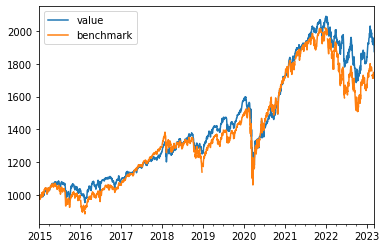

In [29]:
from core.analytics import metrics
pri = pd.concat([strategy.value_df,make_bm(dict(ACWI=0.9, BND=0.1))], axis=1)
pri.plot()
print(metrics.ann_returns(pri))
print(metrics.sharpe_ratios(pri))